# House Prediction - Bondì, Comella, Gambino

Effettuiamo l'import delle librerie necessari per l'analisi e la predizione. Inoltre includiamo la libreria seaborn per la visualizzazione dei grafici.

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Importiamo i dati di train e di test forniti

In [18]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/train.csv')
na_cols = train.columns[train.isna().any()].tolist()
k = 1

Analizziamo, per prima cosa, il grafico della distribuzione normale e il QQ Plot per i dati del prezzo di vendita delle case

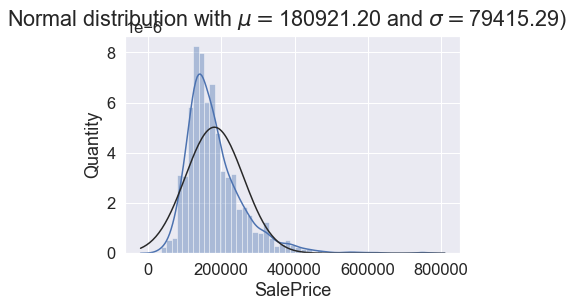

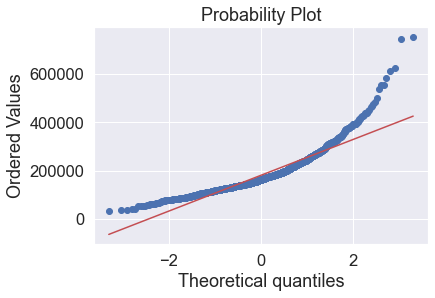

In [19]:
sns.distplot(train['SalePrice'], fit=norm)
plt.ylabel('Quantity')

(mu, sigma) = norm.fit(train['SalePrice'])
plt.suptitle(
    'Normal distribution with $\mu=${0:.2f} and $\sigma=${1:.2f})'.format(mu, sigma))

# Dist plot (norm and factual)
fig = plt.figure()

# QQ Plot (quantili di una distribuzione)
res = stats.probplot(train['SalePrice'], plot=plt)


Notiamo che la distribuzione tende verso destra. Applichiamo una trasformazione logaritmica e verifichiamo le differenze

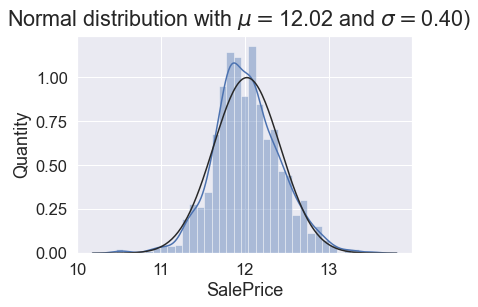

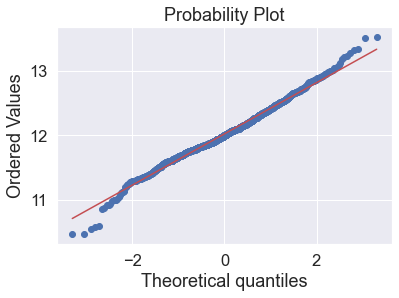

In [15]:
train['SalePrice'] = np.log(train['SalePrice'])

(mu, sigma) = norm.fit(train['SalePrice'])
plt.suptitle(
    'Normal distribution with $\mu=${0:.2f} and $\sigma=${1:.2f})'.format(mu, sigma))

# Dist plot (norm and factual)
sns.distplot(train['SalePrice'], fit=norm)
plt.ylabel('Quantity')
fig = plt.figure()

# QQ Plot
res = stats.probplot(train['SalePrice'], plot=plt)


Adesso la distribuzione sembra migliore. Manteniamo tale trasformazione e sull'output in uscita applicheremo un esponenziale. 

# Feature
Da una prima analisi del dataset si notano diversi attributi che influenzano maggiormente il prezzo di vendita: OverallQual, GarageCars, GrLivArea, etc.

Verifichiamo i livelli di correlazione di tutte le label con il SalePrice attraverso la matrice di correlazione.

In [16]:
corrMatrix = train.corr()
corrMatrix[['SalePrice']].sort_values(
    by='SalePrice', ascending=False).style.background_gradient(cmap='Blues', axis=None)


,SalePrice
SalePrice,1.000000
OverallQual,0.817184
GrLivArea,0.700927
GarageCars,0.680625
GarageArea,0.650888
TotalBsmtSF,0.612134
1stFlrSF,0.596981
FullBath,0.594771
YearBuilt,0.586570
YearRemodAdd,0.565608


Mostriamo graficamente la correlazione che c'è tra il SalePrice e le principali feature correlate. Prendiamo le prime, ottenute sopra, con la correlazione maggiore.

Notiamo che l'OverallQual ha un correlazione molto elevata, come si poteva immaginare. Dunque mostriamo i grafici evidenziando l'OverallQual in relazione alle diverse feature.

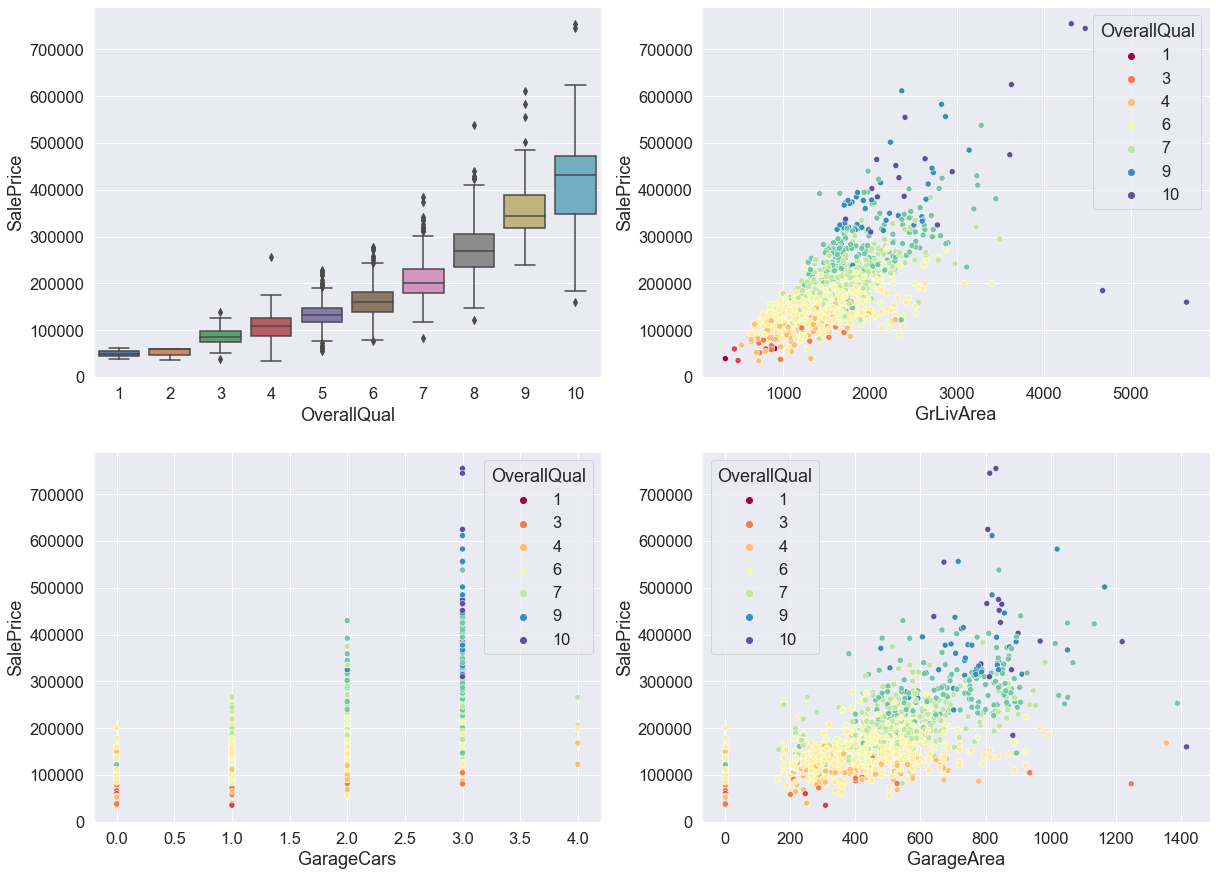

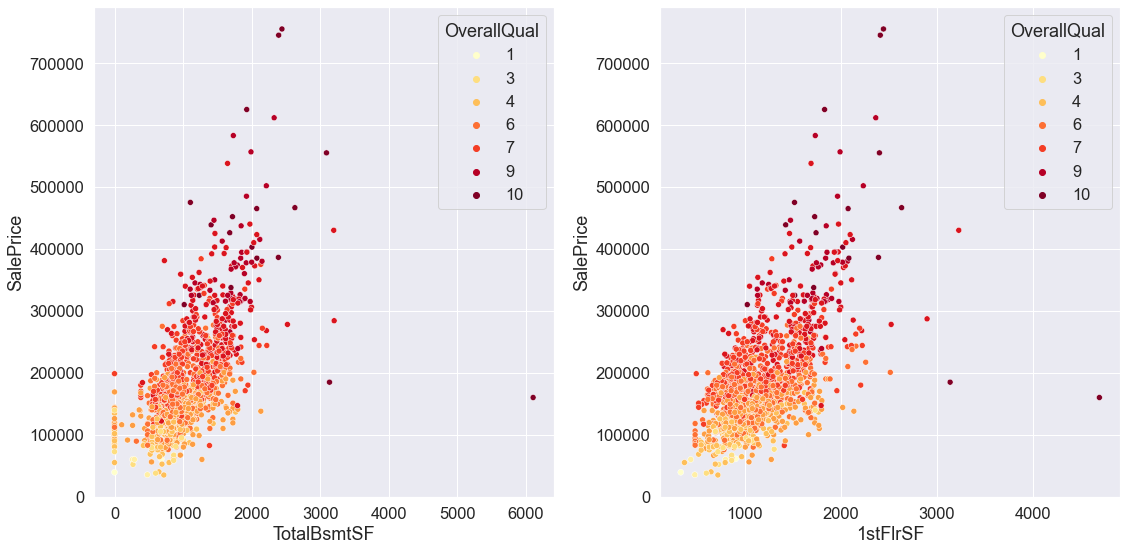

In [20]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

# (Corr= 0.817185) Box plot overallqual/salePrice
fig1 = fig.add_subplot(221); sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

# (Corr= 0.700927) GrLivArea vs SalePrice plot
fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.680625) GarageCars vs SalePrice plot
fig3 = fig.add_subplot(223); 
sns.scatterplot(x = train.GarageCars, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.650888) GarageArea vs SalePrice plot
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train.GarageArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig5 = plt.figure(figsize=(16, 8))
fig6 = fig5.add_subplot(121); 
sns.scatterplot(y = train.SalePrice , x = train.TotalBsmtSF, hue=train.OverallQual, palette= 'YlOrRd')

fig7 = fig5.add_subplot(122); 
sns.scatterplot(y = train.SalePrice, x = train['1stFlrSF'], hue=train.OverallQual, palette= 'YlOrRd')

plt.tight_layout(); plt.show()

Si nota che il prezzo complessivo della casa aumenta con l'aumentare della qualità generale (OverallQual).

Verifichiamo adesso il resto delle feature con una correlazione > 0.50 e le mostriamo in dei PairPlot

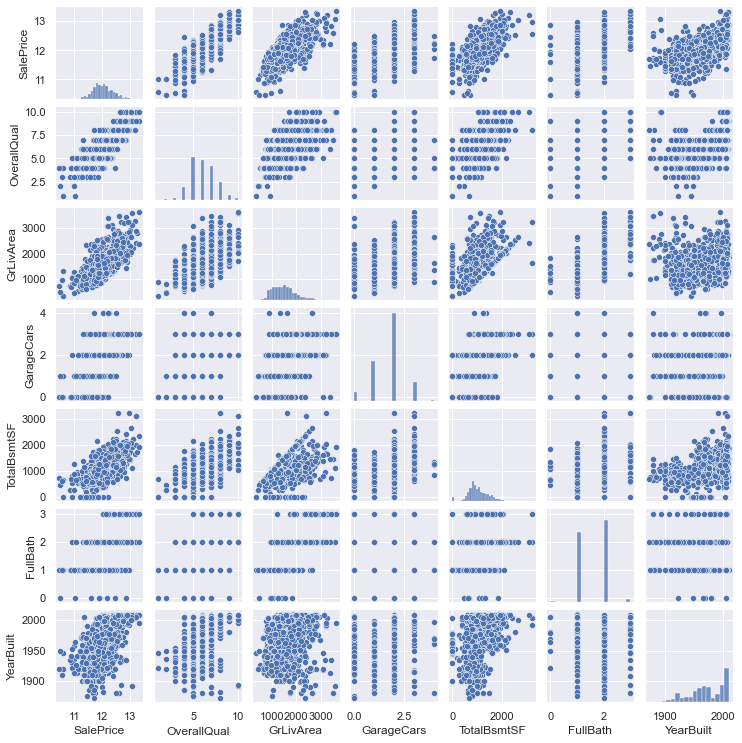

In [11]:
sns.set()
#label delle feature di nostro interesse
cols = ['SalePrice', 'OverallQual', 'GrLivArea',
        'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
pairp = sns.pairplot(train[cols], size=1.5)
plt.show()


Da qui notiamo la correlazione tra il 'SalePrice' e le feature più importanti, ma anche la correlazione tra queste feature stesse.

# Pulizia delle feature

Analizziamo la quantità di dati mancanti sulle feature

In [31]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() /
           train.shape[0]).sort_values(ascending=False)

missing = pd.concat([total, percent*100], axis=1, keys=['Totali', '% mancanti'])
missing.head(15)


,Totali,% mancanti
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageCond,81,5.555556
GarageQual,81,5.555556


Applichiamo le stesse trasformazioni sui dati di test così da evitare duplicazione di codice

In [32]:
for dataset in (train, test):
    #NA (not applicable) vale come "None" per tali features
    for parameter in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                      'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                      'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2', "MasVnrType", 'MSSubClass'):
        dataset[parameter] = dataset[parameter].fillna("None")

    #Valori numerici riempiti con 0
    for parameter in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
                      'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
                      'BsmtHalfBath', "MasVnrArea"):
        dataset[parameter] = dataset[parameter].fillna(0)

    #le feature con pochi dati mancanti possono essere riempiti con i valori più frequenti
    for parameter in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
                      'SaleType', 'Utilities'):
        dataset[parameter] = dataset[parameter].fillna(
            dataset[parameter].mode()[0])

    #dalle info abbiamo che NA == Typ per la feature Functional
    dataset['Functional'] = dataset["Functional"].fillna("Typ")

    #LotFrontage con la mediana del LotFrontage dello stesso quartiere
    dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))


In [33]:
#check for any missing values
print(f"Null value su train: {train.isnull().sum().max()}")
print(f"Null value su test: {test.isnull().sum().max()}")


Null value su train: 0
Null value su test: 0


Visualizziamo nuovamente le informazioni sul grafico eliminando i due casi anomali per GrLivArea > 4500.

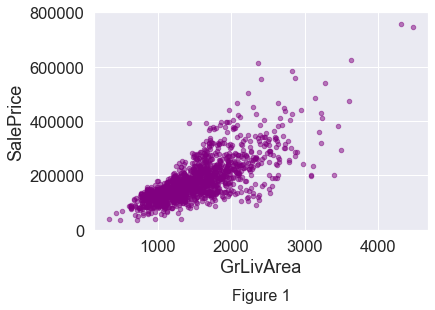

In [34]:
#Drop delle anomalie
train.drop(train[train.GrLivArea > 4500].index, inplace=True)

train.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000), c='purple', alpha=0.5)
plt.title('Figure {}'.format(k), y=-0.35, fontsize=16)

plt.show()


Adesso possiamo passare all'aggregazione delle principali feature per facilitarne l'analisi.

In [35]:
train['New'] = train['OverallQual'] * train['GarageArea'] * train['GrLivArea']
test['New'] = test['OverallQual'] * test['GarageArea'] * test['GrLivArea']

# Inizializzazione Spark

Attraverso Apache Spark possiamo processare, in maniera performante, una grande quantità di dati. La sua particolarità è la possibilità di distribuire i processi su differenti computer. 

In [36]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

Una SparkSession è un entry point per Spark per lavorare al meglio con RDD (resilient distributed dataset), DataFrame, and Dataset. 
Creiamo una spark session per inizializzare l'applicazione. Attraverso la dicitura local[2] indichiamo lo Spark Master URL come localhost utilizzando 2 core

In [ ]:
spark_session = SparkSession.builder.master("local[2]").appName("HousingRegression").getOrCreate()

Quando viene creata una SparkSession, questi inizializza automaticamente uno SparkContext.
Lo SparkContext è responsabile direttamente della connessione al Cluster.

In [ ]:
spark_context = spark_session.sparkContext

A questo punto creiamo due SparkDataFrame rispettivamente con i dati di test e di train. 
Eliminiamo le colonne con i dati vuoti dal dataframe di train e cancelliamo la colonna del SalePrice.
A questo punto prendiamo dal dataframe di test le colonne rimaste in quello di train.

In [37]:
train_df = spark_session.createDataFrame(train)
test_df = spark_session.createDataFrame(test)

train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)

Facciamo un cast specifico delle proprietà che potrebbero causare anomalie, forzandole a interi.


In [38]:
from pyspark.sql.types import IntegerType

test_df = test_df.withColumn("BsmtFinSF1", test_df["BsmtFinSF1"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFinSF2", test_df["BsmtFinSF2"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtUnfSF", test_df["BsmtUnfSF"].cast(IntegerType()))
test_df = test_df.withColumn("TotalBsmtSF", test_df["TotalBsmtSF"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFullBath", test_df["BsmtFullBath"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtHalfBath", test_df["BsmtHalfBath"].cast(IntegerType()))
test_df = test_df.withColumn("GarageCars", test_df["GarageCars"].cast(IntegerType()))
test_df = test_df.withColumn("GarageArea", test_df["GarageArea"].cast(IntegerType()))

Prendiamo tutte le categorical feature (feature stringhe) da passare allo StringIndexer per indicizzare i dati di train.

In [20]:
train_string_columns = []

for col, dtype in train_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)

Arrivati a questa parte di progetto facciamo l'import di due funzioni dalla libreria pyspark.ml: Pipeline e StringIndexer.

La funzione StringIndexer mappa le colonne di una tabella e assegna loro un indice che di solito parte da 0. Se l'input di una colonna è numerico, facciamo il cast a string e indicizziamo il valore della stringa.

Creiamo un pipeline per leggere più dati contemporaneamente, la funzione pipeline funge da stimatore. Nel nostro caso possiamo vedere che dopo che invochiamo la funzione pipeline vengono eseguiti i metodi fit (stimatore) e il metodo transform (trasformazione).

In [21]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+'_index',
                          handleInvalid='keep').fit(train_df) for column in train_string_columns]


pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df) #In questo passaggio vediamo la funzione pipeline in azione. Prima eseguiamo una stima (fit) e poi una trasformazione.

print(len(train_indexed.columns)) #Per mostrare il risultato della nostra pipeline, eseguiamo la print del numero di colonna.

90


Ripetiamo la procedura per i dati del Dataframe di test.

In [22]:
test_string_columns = []

for col, dtype in test_df.dtypes:
    if dtype == 'string':
        test_string_columns.append(col)

indexers2 = [StringIndexer(inputCol=column, outputCol=column+'_index',
                           handleInvalid='keep').fit(test_df) for column in test_string_columns]

pipeline2 = Pipeline(stages=indexers2)
test_indexed = pipeline2.fit(test_df).transform(test_df)

print(len(test_indexed.columns))

Prendiamo tutte le colonne che non sono stringhe e aggiorniamo le variabili dei dataframe con le sole colonne in questione.

In [25]:
def get_dtype(df, colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed, col) != 'string':
        num_cols_train.append(str(col))

#Ripetiamo per i dati di test
num_cols_test = []
for col in test_indexed.columns:
    if get_dtype(test_indexed, col) != 'string':
        num_cols_test.append(str(col))

train_indexed = train_indexed.select(num_cols_train)
test_indexed = test_indexed.select(num_cols_test)

Mostriamo il numero di colonne risultante per i dati di test e di train. Notiamo che i dati di train hanno una colonna in più che corrisponde al "SalePrice"

In [26]:
print(len(train_indexed.columns))
print(len(test_indexed.columns))

63
62


# Model building (MLib)

Il primo passaggio che andiamo ad effettuare nel Model Building è la vettorizzazione. Questa viene utilizzata per leggere più righe in una tabella o per calcolare più righe contemporaneamente. Lo scopo è quello di migliorar le prestazioni del programma Spark. Creiamo un vector per i dati di train e analogamente per i dati di test.

Attraverso pyspark.ml.feature possiamo estrarre, trasformare, ridurre e selezionare le feature utili al ML.

La funzione lit crea una colonna di valore letterale, mentre la funzione VectorAssembler unisce più colonne in una colonna vettoriale.

In [27]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler

# Questa funzione mi permette di costruire una colonna vEttoriale che non tiene conto del Sale price
# Ha come output delle fetures e setta gli "invalid data = keep" per mantenerli
vectorAssembler = VectorAssembler(inputCols=train_indexed.drop("SalePrice").columns, outputCol='features').setHandleInvalid("keep")    

train_vector = vectorAssembler.transform(train_indexed)

#Ripetiamo l'operazione per i dati di test
vectorAssembler2 = VectorAssembler(inputCols=test_indexed.columns, outputCol='features').setHandleInvalid("keep")

test_vector = vectorAssembler2.transform(test_indexed)

#Impostiamo nei dati di test il saleprice a 0 perchè dobbiamo predirlo e quindi non deve essere utilizzato
test_vector = test_vector.withColumn("SalePrice", lit(0))


Con la funzione randomSplit andiamo a splittare il nostro DataFrame con dei pesi scelti da noi, in questo caso 0.7 e 0.3. Con questi due valori andiamo a stabilire qual è la soglia di accettazione dei nostri dati e
attraverso la funzione split() effettiamo la suddivisione. 

Spark utilizza il campionamento di Bernoulli, che può essere riassunto come la generazione di numeri casuali per un elemento (punto dati) e l'accettazione in una divisione se il numero generato rientra in un determinato intervallo, determinato dal rapporto di divisione. 

In [28]:
# Train-test split
splits = train_vector.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

Creiamo dapprima un modello con la Regressione Lineare. Questa è usata per predire il valore di una variabile sulla base del valore di altre variabili. In particolare la variabile che dobbiamo stimare è detta variabile dipendente (SalePrice) mentre le altre sono interdipendenti (features). Creato il modello e montati i dati di train, stampiamo la radice dell'errore quadratico medio (RMSE) e il coefficiente di determinazione.

L'errore quadratico medio è pari alla somma della varianza, variabile che misura la variabilità dei valori assunti, e del quadrato del bias di uno stimatore.

Il coeffiente di determinazione è una misura che indica quanto è corretto il modello statistico utilizzato rispetto alla variabilità dei dati. Varia tra 0 e 1, con 0 si ha un mancata predizione del risultato e con 1 si ha la predizione perfetta. In generale più è prossimo a 1 migliore è la stima.

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

#Creazione del modello
lr = LinearRegression(featuresCol='features', labelCol='SalePrice', maxIter=10, regParam=0.8, elasticNetParam=0.1)
lr_model = lr.fit(train)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

lr_predictions = lr_model.transform(val)
#Mostriamo le prime 5 prediction
lr_predictions.select("prediction", "SalePrice", "features").show(5)

#Prediction
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SalePrice", metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(lr_predictions)) #Cos'è questo print?


RMSE: 0.226779
r2: 0.669642
+------------------+------------------+--------------------+
|        prediction|         SalePrice|            features|
+------------------+------------------+--------------------+
|12.019473769971633|12.109010932687042|(62,[0,1,2,3,4,5,...|
|  12.1390160808882| 12.31716669303576|(62,[0,1,2,3,4,5,...|
|11.865884268420327|11.870599909242044|(62,[0,1,2,3,4,5,...|
| 12.03365570093264| 11.77452020265869|(62,[0,1,2,3,4,5,...|
|11.827944152406944|11.678439903447801|(62,[0,1,2,3,4,5,...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.654285


Visto il risultato precedente, proviamo un ulteriore modello: Random Forest. L'obiettivo è quello di ottenere un risultato migliore del coeffiente di determinazione.

------------------------------- TODO Piccola spiegazione sul randomForest

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='SalePrice',
                           maxDepth=20,
                           minInstancesPerNode=2,
                           bootstrap=True
                           )
rf_model = rf.fit(train)

rf_predictions = rf_model.transform(val)
rf_predictions.select("prediction", "SalePrice", "features").show(5)

rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SalePrice", metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))


+------------------+------------------+--------------------+
|        prediction|         SalePrice|            features|
+------------------+------------------+--------------------+
|12.095983592244329|12.109010932687042|(62,[0,1,2,3,4,5,...|
|12.340223657218589| 12.31716669303576|(62,[0,1,2,3,4,5,...|
|11.909858623200854|11.870599909242044|(62,[0,1,2,3,4,5,...|
|11.934765019377052| 11.77452020265869|(62,[0,1,2,3,4,5,...|
| 11.70466418450581|11.678439903447801|(62,[0,1,2,3,4,5,...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.858286


# Prediction e Submission

Effettuiamo la prediction con il modello del random forest

In [31]:
from pyspark.sql.types import FloatType, IntegerType
rf_predictions2 = rf_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = rf_predictions2.select("Id", "prediction")
pred = pred.withColumnRenamed("prediction", "SalePrice")


#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))

Salviamo la prediction

In [32]:
pred_pd = pred.toPandas()
save = pred_pd.to_csv("submission.csv", index=False)
save

Stampiamo il risultato della prediction

In [33]:
pred_pd

,Id,SalePrice
0,1,12.232677
1,2,12.095984
2,3,12.340223
3,4,11.987466
4,5,12.514671
...,...,...
1455,1456,12.072702
1456,1457,12.231549
1457,1458,12.272266
1458,1459,11.793706
